In [2]:
from PYME.localization.FitFactories import DumbellFitR as dbfr
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.optimize import fmin
from PYME.IO.image import ImageStack
from scipy import ndimage

In [3]:
def g2a(x, y, sig):
    return (1 / (2 * sig**2)) * np.exp((3/2)) * (x**2 - sig**2) * np.exp(-(x**2 + y**2) / (2 * sig**2))
def g2b(x, y, sig):
    return (1 / (2 * sig**2)) * np.exp((3/2)) * x*y*np.exp(-(x**2 + y**2) / (2 * sig**2))
def g2c(x, y, sig):
    return (1 / (2 * sig**2)) * np.exp((3/2)) * (y**2 - sig**2) * np.exp(-(x**2 + y**2) / (2 * sig**2))


def h2a(x, y, sig):
    return (np.exp((3/2)) / (24 * np.pi * sig**3)) * np.exp(-(x**2 + y**2) / (2 * sig**2)) * (4 * (2 * np.pi)**(1/2) * x**3 - 3 * sig * (8 * (2 * np.pi)**(1/2) * sig - (np.log(1/sig**2) + np.log(sig**2))) * x)
def h2b(x, y, sig):
    return (np.exp((3/2)) / (24 * np.pi * sig**3)) * np.exp(-(x**2 + y**2) / (2 * sig**2)) * (4 * (2 * np.pi)**(1/2) * x**2 - sig * (8 * (2 * np.pi)**(1/2) * sig - (np.log(1/sig**2) + np.log(sig**2)))) * y
def h2c(x, y, sig):
    return (np.exp((3/2)) / (24 * np.pi * sig**3)) * np.exp(-(x**2 + y**2) / (2 * sig**2)) * (4 * (2 * np.pi)**(1/2) * y**2 - sig * (8 * (2 * np.pi)**(1/2) * sig - (np.log(1/sig**2) + np.log(sig**2)))) * x
def h2d(x, y, sig):
    return (np.exp((3/2)) / (24 * np.pi * sig**3)) * np.exp(-(x**2 + y**2) / (2 * sig**2)) * (4 * (2 * np.pi)**(1/2) * y**3 - 3 * sig * (8 * (2 * np.pi)**(1/2) * sig - (np.log(1/sig**2) + np.log(sig**2))) * y)


def computeStrengthMap(sigma, image):
    
    roiHalfSize = 10 # [pixels]

    xx = np.mgrid[(-roiHalfSize):(roiHalfSize + 1)]
    yy = np.mgrid[(-roiHalfSize):(roiHalfSize + 1)]


    X, Y = xx[:, None], yy[None, :]

    f1 = g2a(Y, X, sigma)
    f2 = g2b(Y, X, sigma)
    f3 = g2c(Y, X, sigma)

    g2a_xy = ndimage.convolve(image, f1)
    g2b_xy = ndimage.convolve(image, f2)
    g2c_xy = ndimage.convolve(image, f3)
    
    fha = h2a(Y, X, sigma)
    fhb = h2b(Y, X, sigma)
    fhc = h2c(Y, X, sigma)
    fhd = h2d(Y, X, sigma)

    h2a_xy = ndimage.convolve(image, fha)
    h2b_xy = ndimage.convolve(image, fhb)
    h2c_xy = ndimage.convolve(image, fhc)
    h2d_xy = ndimage.convolve(image, fhd)

    c_2= 0.5 * (g2a_xy**2 - g2c_xy**2) \
                + 0.46875*(h2a_xy**2 - h2d_xy**2) \
                + 0.28125*(h2b_xy**2 - h2c_xy**2) \
                + 0.1875 * (h2a_xy*h2c_xy - h2b_xy * h2d_xy)
    c_3 = - g2a_xy*g2b_xy - g2b_xy * g2c_xy \
                - 0.9375 * (h2c_xy * h2d_xy + h2a_xy * h2b_xy) \
                - 1.6875 * h2b_xy * h2c_xy - 0.1875 * h2a_xy * h2d_xy

    
    strengthMap = np.sqrt(c_2 ** 2 + c_3 ** 2)
    
    return strengthMap


def StrengthVsSigma(sigmas, image):
        
    strengths = np.asarray(np.zeros(sigmas.size), dtype=float)
    
    for i in list(range(0,sigmas.size)):
    
        strengthMap = computeStrengthMap(sigmas[i], image)
        strengths[i] = np.max(strengthMap)
     
    plt.figure()
    plt.plot(sigs, strengths)
    print("optimal sigma = " + str(sigs[np.unravel_index(np.argmax(strengths), strengths.shape)[0]]))
    
    return strengths

def OptimalSigmabyFrame(PSFStack, sigmas):
    
    optSigmas = np.asarray(np.zeros(PSFStack.shape[2]), dtype=float)
    maxX = np.asarray(np.zeros(PSFStack.shape[2]), dtype=float)
    maxY = np.asarray(np.zeros(PSFStack.shape[2]), dtype=float)
    
    for j in list(range(0,PSFStack.shape[2])):
    
        strengths = np.asarray(np.zeros(sigmas.size), dtype=float)

        X = np.asarray(np.zeros(sigmas.size), dtype=float)
        Y = np.asarray(np.zeros(sigmas.size), dtype=float)
        
        for i in list(range(0,sigmas.size)):

            
            strengthMap = computeStrengthMap(sigmas[i], PSFStack[:,:,j])
            strengths[i] = np.max(strengthMap)
            X[i] = np.unravel_index(np.argmax(strengthMap), strengthMap.shape)[1]
            Y[i] = np.unravel_index(np.argmax(strengthMap), strengthMap.shape)[0]

        optSigmas[j] = sigs[np.unravel_index(np.argmax(strengths), strengths.shape)[0]]
        maxX[j] = X[np.unravel_index(np.argmax(strengths), strengths.shape)[0]]
        maxY[j] = Y[np.unravel_index(np.argmax(strengths), strengths.shape)[0]]
        
    plt.figure()
    plt.plot(list(range(0,PSFStack.shape[2])), optSigmas)
    plt.xlabel("Frame")
    plt.ylabel("Optimal Filter Sigma")
    
    return optSigmas, strengths, maxX, maxY
    

def StrengthVsZ(PSFStack, sigma, l, s, midSlice):
    
    A=1
    S = lambda x: pow(2.718281828459045,3)*pow(3.141592653589793,3)*pow(pow(A,4)*pow(s,8)*pow(x,16)*pow((pow(s,2)+pow(x,2)),-6)*pow((-1*pow(2.718281828459045,-0.25*pow((pow(s,2)+pow(x,2)),-1))*pow((math.erf(0.5*(-1+l)*pow(2,-0.5)*pow((pow(s,2)+pow(x,2)),-0.5))+-1*math.erf(0.5*(1+l)*pow(2,-0.5)*pow((pow(s,2)+pow(x,2)),-0.5))),2)+pow(2.718281828459045,-0.25*pow((1+l),2)*pow((pow(s,2)+pow(x,2)),-1))*pow(math.erf(0.5*pow(2,-0.5)*pow((pow(s,2)+pow(x,2)),-0.5)),2)*pow((1+l+-1*(-1+l)*pow(2.718281828459045,0.5*l*pow((pow(s,2)+pow(x,2)),-1))),2)),2),0.5)
    normFactor = S(sigma)
    
    strengths = np.asarray(np.zeros(PSFStack.shape[2]), dtype=float)
    dhAmplitudes = np.asarray(np.zeros(PSFStack.shape[2]), dtype=float)
    maxX = np.asarray(np.zeros(PSFStack.shape[2]), dtype=float)
    maxY = np.asarray(np.zeros(PSFStack.shape[2]), dtype=float)
    
    for i in list(range(0,PSFStack.shape[2])):
    
        strengthMap = computeStrengthMap(sigma, PSFStack[:,:,i])
        strengths[i] = np.max(np.sqrt(strengthMap/normFactor))
        dhAmplitudes[i] = np.max(PSFStack[:,:,i])
        maxX[i] = np.unravel_index(np.argmax(strengthMap), strengthMap.shape)[1]
        maxY[i] = np.unravel_index(np.argmax(strengthMap), strengthMap.shape)[0]
                                   
        
        
        
    plt.figure()
    plt.imshow(np.sqrt(computeStrengthMap(sigma, PSFStack[:,:,midSlice])/normFactor), origin="lower")
                                   
    plt.figure()
    plt.imshow(PSFStack[:,:,midSlice], origin="lower")
    plt.scatter(maxX, maxY, color="red")
    
    plt.figure()
    plt.plot(list(range(0,PSFStack.shape[2])), dhAmplitudes)
    plt.xlabel("Frame")
    plt.ylabel("DH Amplitude")
    
    plt.figure()
    plt.plot(list(range(0,PSFStack.shape[2])), strengths)
    plt.xlabel("Frame")
    plt.ylabel("Max Strength")
    
    plt.figure()
    plt.plot(list(range(0,PSFStack.shape[2])), strengths/dhAmplitudes)
    plt.xlabel("Frame")
    plt.ylabel("Max Strength/DH Amplitude")
    return strengths, maxX, maxY

In [4]:
im = ImageStack(filename = "E:/Toxoplasma_Fixed_Cell_Imaging/20240630_MyoH_Single_Color/Z_Stack_2_step_avg_CROP.h5", haveGUI=False)
im.mdh['Camera.NoiseFactor'] = 1.4 # typical for EMCCD with gain > 10
im.mdh['Camera.ElectronsPerCount'] = 12.9  # e-/ADU
im.mdh['Camera.TrueEMGain'] = 272
im.mdh['Camera.ADOffset'] = 110 # [ADU]
im.mdh['voxelsize.x'] = 0.1175 # [um]
im.mdh['voxelsize.y'] = 0.1175 # [um]

dh_stack=np.squeeze(im.data_xytc[:,:,:,0]) 


filename == E:\Toxoplasma_Fixed_Cell_Imaging\20240630_MyoH_Single_Color\Z_Stack_2_step_avg_CROP.h5
E:\Toxoplasma_Fixed_Cell_Imaging\analysis\20240630_MyoH_Single_Color\Z_Stack_2_step_avg_CROP.h5r


DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\ProgramData\\Miniconda3\\envs\\dhpymedev\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmtt10.ttf', name='cmtt10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\ProgramData\\Miniconda3\\envs\\dhpymedev\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmmi10.ttf', name='cmmi10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\ProgramData\\Miniconda3\\envs\\dhpymedev\\lib\

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\ProgramData\\Miniconda3\\envs\\dhpymedev\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizFourSymBol.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\ProgramData\\Miniconda3\\envs\\dhpymedev\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUniBol.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\ProgramData\\Miniconda3\\envs\\dhpymedev\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\ProgramData\\Miniconda3\\e

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BRITANIC.TTF', name='Britannic Bold', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\simsun.ttc', name='SimSun', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ROCKI.TTF', name='Rockwell', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GOUDOS.TTF', name='Goudy Old Style', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ROCKBI.TTF', name='Rockwell', style='italic', variant='normal', weight=700, stretch='normal',

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ARIALNBI.TTF', name='Arial', style='italic', variant='normal', weight=700, stretch='condensed', size='scalable')) = 7.8986363636363635
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BROADW.TTF', name='Broadway', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\AGENCYR.TTF', name='Agency FB', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GLECB.TTF', name='Gloucester MT Extra Condensed', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ERASDEMI.TTF', name='Eras Demi ITC', style='normal', variant='nor

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\pala.ttf', name='Palatino Linotype', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\TCCEB.TTF', name='Tw Cen MT Condensed Extra Bold', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BELL.TTF', name='Bell MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\PERB____.TTF', name='Perpetua', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\YuGothL.ttc', name='Yu Gothic', style='normal', variant='normal', weight=3

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\STENCIL.TTF', name='Stencil', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\himalaya.ttf', name='Microsoft Himalaya', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\corbeli.ttf', name='Corbel', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\COPRGTB.TTF', name='Copperplate Gothic Bold', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\constan.ttf', name='Constantia', style='normal', variant='normal', weight=400,

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\malgunsl.ttf', name='Malgun Gothic', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\MISTRAL.TTF', name='Mistral', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\taileb.ttf', name='Microsoft Tai Le', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\simsunb.ttf', name='SimSun-ExtB', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\corbell.ttf', name='Corbel', style='normal', variant='normal', weight=300, stretch='

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segoepr.ttf', name='Segoe Print', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\YuGothM.ttc', name='Yu Gothic', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\symbol.ttf', name='Symbol', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FRABK.TTF', name='Franklin Gothic Book', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\CENSCBK.TTF', name='Century Schoolbook', style='normal', variant='normal', weight=400, st

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\impact.ttf', name='Impact', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\times.ttf', name='Times New Roman', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\JUICE___.TTF', name='Juice ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\SitkaB.ttc', name='Sitka Small', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\msyi.ttf', name='Microsoft Yi Baiti', style='normal', variant='normal', weight=400, stretch='n

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\trebucit.ttf', name='Trebuchet MS', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segoeuii.ttf', name='Segoe UI', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GARABD.TTF', name='Garamond', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\CENTAUR.TTF', name='Centaur', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BOD_BLAI.TTF', name='Bodoni MT', style='italic', variant='normal', weight=900, stretch='normal',

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\ProgramData\\Miniconda3\\envs\\dhpymedev\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmtt10.ttf', name='cmtt10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\ProgramData\\Miniconda3\\envs\\dhpymedev\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmmi10.ttf', name='cmmi10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\ProgramData\\Miniconda3\\envs\\dhpymedev\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUniIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\ProgramData\\Miniconda3\\envs\\dhpymedev\\lib\\site-packages\\matplotlib\\m

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\ProgramData\\Miniconda3\\envs\\dhpymedev\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUniBol.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\ProgramData\\Miniconda3\\envs\\dhpymedev\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\ProgramData\\Miniconda3\\envs\\dhpymedev\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansDisplay.ttf', name='DejaVu Sans Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\ProgramData\\Miniconda3

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\simsun.ttc', name='SimSun', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ROCKI.TTF', name='Rockwell', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GOUDOS.TTF', name='Goudy Old Style', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ROCKBI.TTF', name='Rockwell', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\NirmalaB.ttf', name='Nirmala UI', style='normal', variant='normal', weight=700, stretch='normal', si

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BROADW.TTF', name='Broadway', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\AGENCYR.TTF', name='Agency FB', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GLECB.TTF', name='Gloucester MT Extra Condensed', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ERASDEMI.TTF', name='Eras Demi ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ERASBD.TTF', name='Eras Bold ITC', style='normal', variant='normal', weig

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\TCCEB.TTF', name='Tw Cen MT Condensed Extra Bold', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BELL.TTF', name='Bell MT', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\PERB____.TTF', name='Perpetua', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\YuGothL.ttc', name='Yu Gothic', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\IMPRISHA.TTF', name='Imprint MT Shadow', style='normal', variant='normal', wei

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\himalaya.ttf', name='Microsoft Himalaya', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\corbeli.ttf', name='Corbel', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\COPRGTB.TTF', name='Copperplate Gothic Bold', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\constan.ttf', name='Constantia', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\verdanab.ttf', name='Verdana', style='normal', variant='normal', weight=700

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\malgunsl.ttf', name='Malgun Gothic', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\MISTRAL.TTF', name='Mistral', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\taileb.ttf', name='Microsoft Tai Le', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\simsunb.ttf', name='SimSun-ExtB', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\corbell.ttf', name='Corbel', style='normal', variant='normal', weight=300, stretch='

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segoepr.ttf', name='Segoe Print', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\YuGothM.ttc', name='Yu Gothic', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\symbol.ttf', name='Symbol', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FRABK.TTF', name='Franklin Gothic Book', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\CENSCBK.TTF', name='Century Schoolbook', style='normal', variant='normal', weight=400, st

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\impact.ttf', name='Impact', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\times.ttf', name='Times New Roman', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\JUICE___.TTF', name='Juice ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\SitkaB.ttc', name='Sitka Small', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\msyi.ttf', name='Microsoft Yi Baiti', style='normal', variant='normal', weight=400, stretch='n

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\trebucit.ttf', name='Trebuchet MS', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segoeuii.ttf', name='Segoe UI', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GARABD.TTF', name='Garamond', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\CENTAUR.TTF', name='Centaur', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BOD_BLAI.TTF', name='Bodoni MT', style='italic', variant='normal', weight=900, stretch='normal',

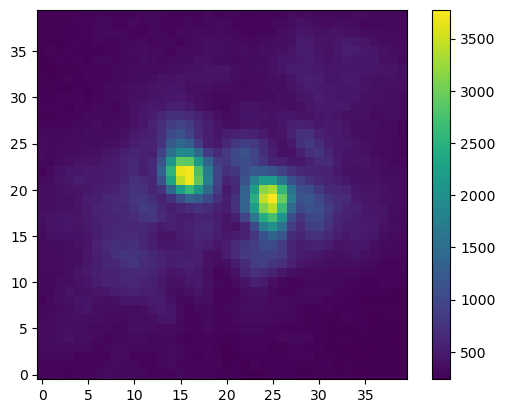

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x000001D2BE3734C8>


optimal sigma = 8.6


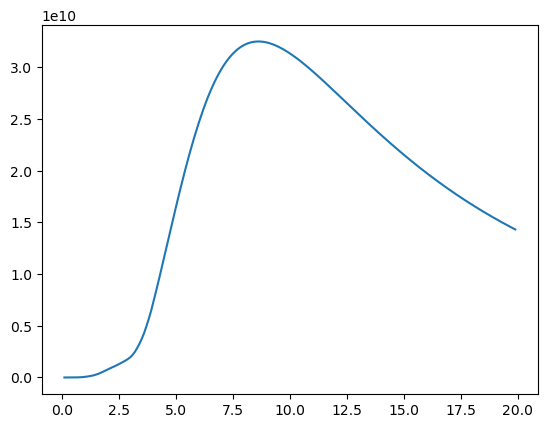

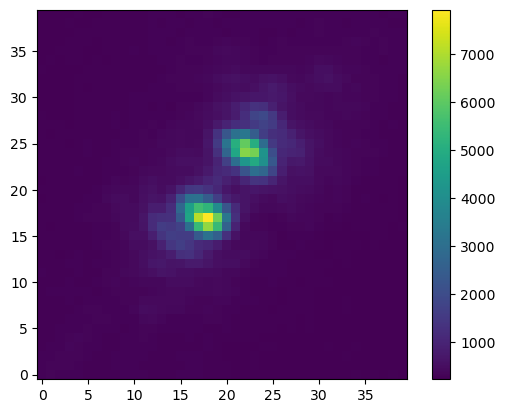

optimal sigma = 8.2


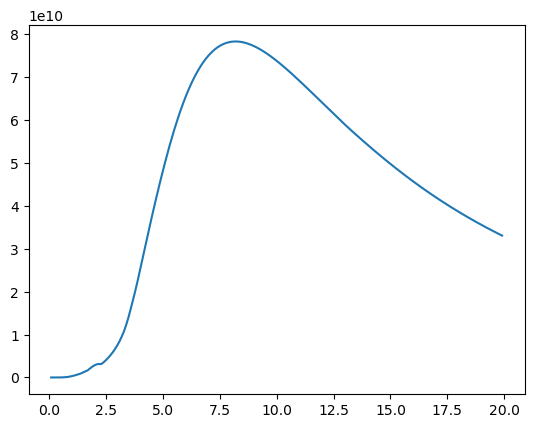

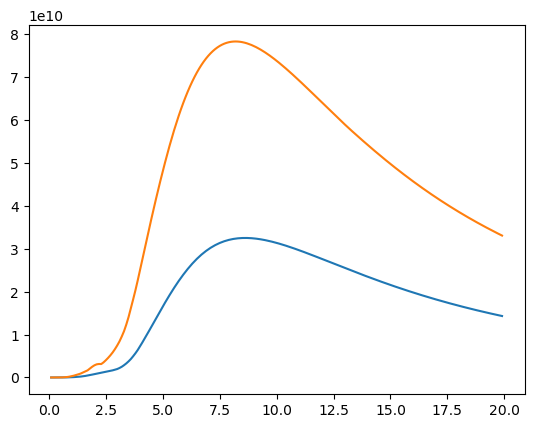

In [5]:
dh3 = dh_stack[:,:,3]
dh25 = dh_stack[:,:,25]

plt.figure()
plt.imshow(dh3, origin="lower")
plt.colorbar()
plt.show()

sigmaUB = 20
sigs = np.array(range(1,sigmaUB*10,1), dtype=float)/10

s3 = StrengthVsSigma(sigs, dh3)

plt.figure()
plt.imshow(dh25, origin="lower")
plt.colorbar()
plt.show()

s25 = StrengthVsSigma(sigs, dh25)

plt.figure()
plt.plot(sigs, s3)
plt.plot(sigs, s25)


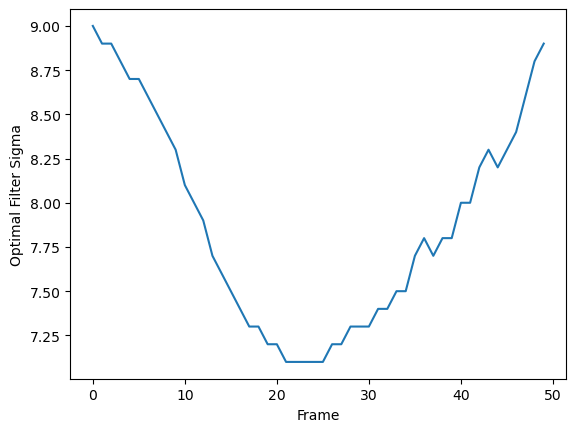

In [27]:
optimalSigs, maxStrengths, maxXforOptSigma, maxYforOptSigma = OptimalSigmabyFrame(dh_stack, sigs)

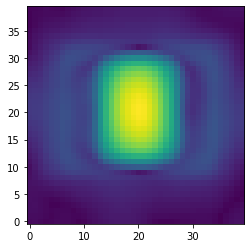

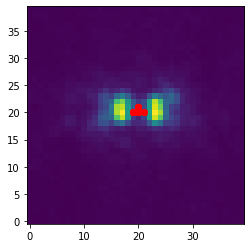

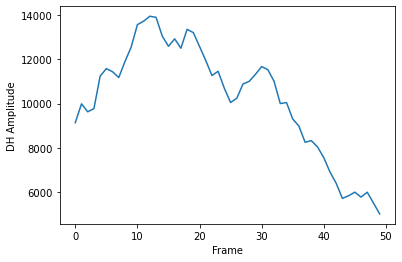

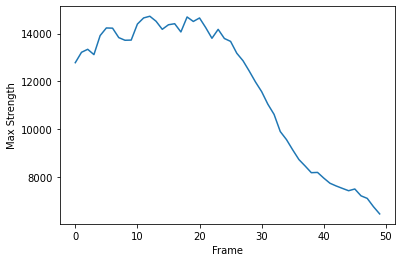

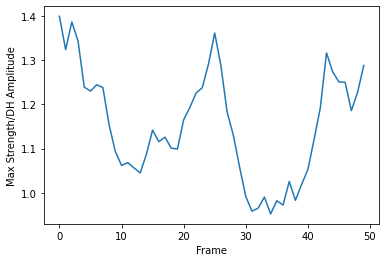

In [37]:
strengths, maxX, maxY = StrengthVsZ(dh_stack, sigma=7.1, l=810/120.0, s=190/120.0, midSlice=25)

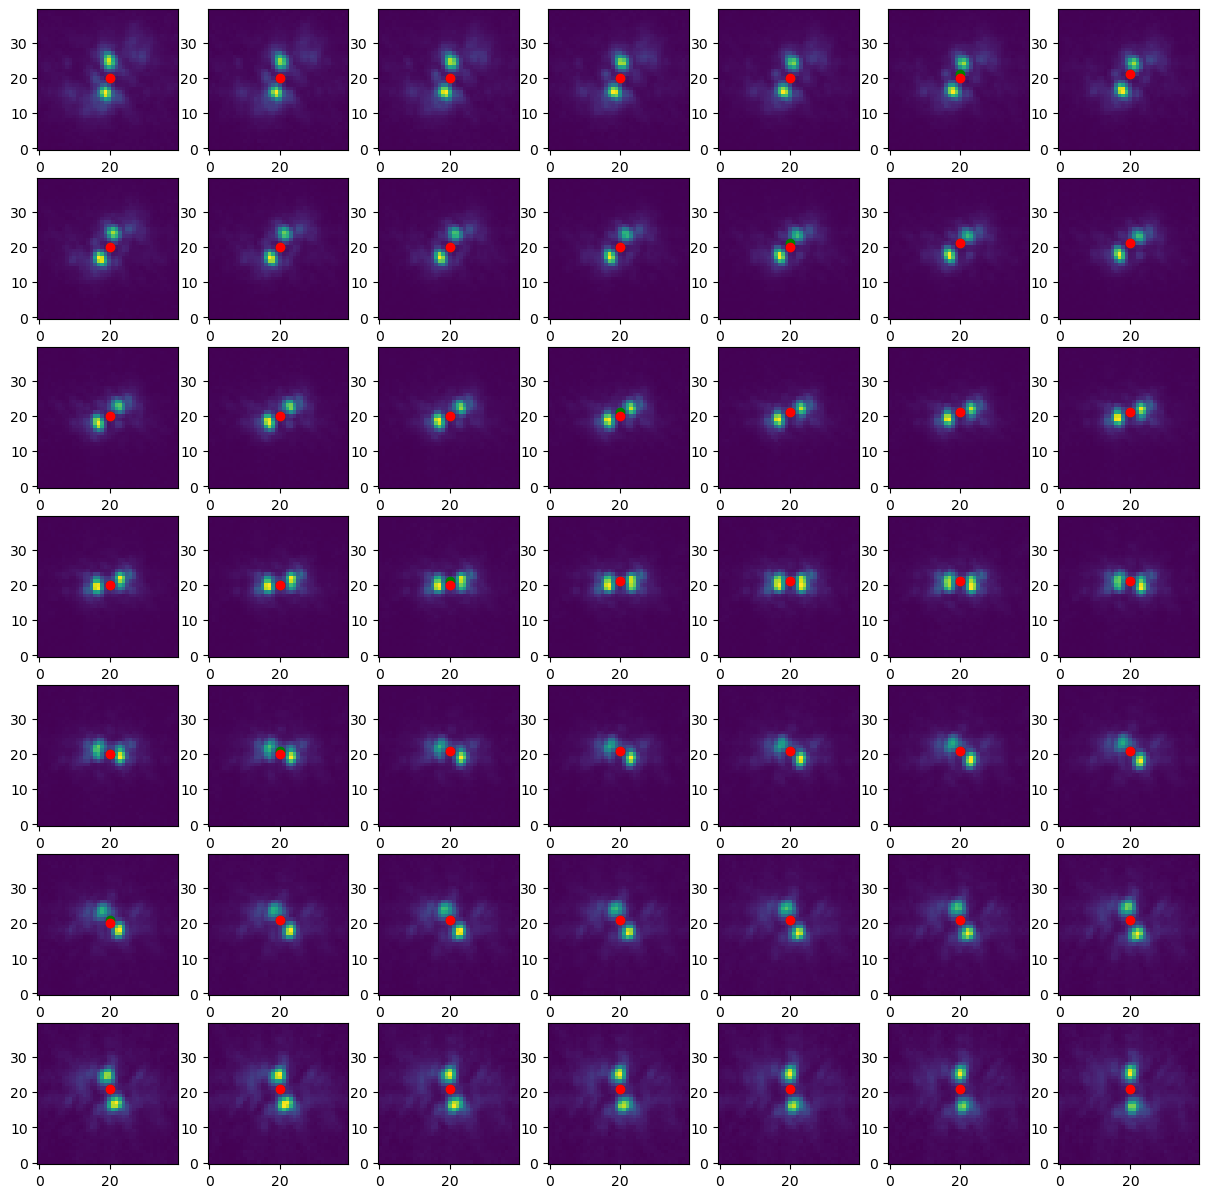

In [31]:
fig, axs = plt.subplots(7, 7, figsize=(15, 15))
count = 0
for i in list(range(7)):
    for j in list(range(7)):
        axs[i, j].imshow(dh_stack[:,:,count], origin="lower")
        axs[i, j].scatter(maxXforOptSigma[i+j], maxYforOptSigma[i+j], color="green")
        axs[i, j].scatter(maxX[i+j], maxY[i+j], color="red")
        count = count + 1
